# Прогнозирование стоимости квартир в Москве 

In [2]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import math

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Загрузка данных

In [3]:
df = pd.read_csv("flats_moscow.csv")

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


In [5]:
# Unnamed ? 
df.drop('Unnamed: 0', axis=1, inplace=True)

# Описание полей

price: цена квартиры в 1000$ / the price of a flat in 1000;

totsp: общая площадь квартиры, кв.м. / total square of a flat, m2;

livesp: жилая площадь квартиры, кв.м. / living square of a flat, m2;

kitsp: площадь кухни, кв.м. / kitchen square, m2;

dist: расстояние от центра в км. / distance to the city center, km;

metrdist: расстояние до метро в минутах / distance to the nearest metro station, min;

walk: 1 – пешком от метро, 0 – на транспорте / 1 - walk to metro, 0 - using transport;

brick: 1 – кирпичный, монолит ж/б, 0 – другой / 1 - brick, monolithic house, 0 - anothers;

floor: 1 – этаж кроме первого и последнего, 0 – иначе / 0 - the first or the last floor, 1 - anothers;

code: число от 1 до 8, обозначающее район города / number from 1 to 8 of the city area:

    1. Север, около Калужско-Рижской линии метро / North of the city, around Kaluzhsko-Rizhskaya metro line;
    
    2. Север, около Серпуховско-Тимирязевской линии метро / North of the city, around Serpukhovsko-Timiryazevskaya metro line;
    
    3. Северо-запад, около Замоскворецкой линиии метро / North-West, around Zamoskvoretskaya metro line;
    
    4. Северо-запад, около Таганско-Краснопресненской линиии метро / North-West, around Tagansko-Krasnopresnenskaya metro line;
    
    5. Юго-восток, около Люблинской линиии метро / South-East, around Lyublinskaya metro line;
    
    6. Юго-восток, около Таганско-Краснопресненской линиии метро / South-East, around Tagansko-Krasnopresnenskaya metro line;
    
    7. Восток, около Калининской линиии метро / East, around Kalininskaya metro line;
    
    8. Восток, около Арбатско-Покровской линиии метро / East, around Arbatsko-Pokrovskaya metro line.

# Анализ данных

In [6]:
num_cols = ['price','totsp','livesp','kitsp','dist', 'metrdist'] 
cat_cols = ['code'] 
bin_cols = ['walk','brick','floor'] 

# Численные столбцы

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'totsp'}>],
       [<AxesSubplot:title={'center':'livesp'}>,
        <AxesSubplot:title={'center':'kitsp'}>],
       [<AxesSubplot:title={'center':'dist'}>,
        <AxesSubplot:title={'center':'metrdist'}>]], dtype=object)

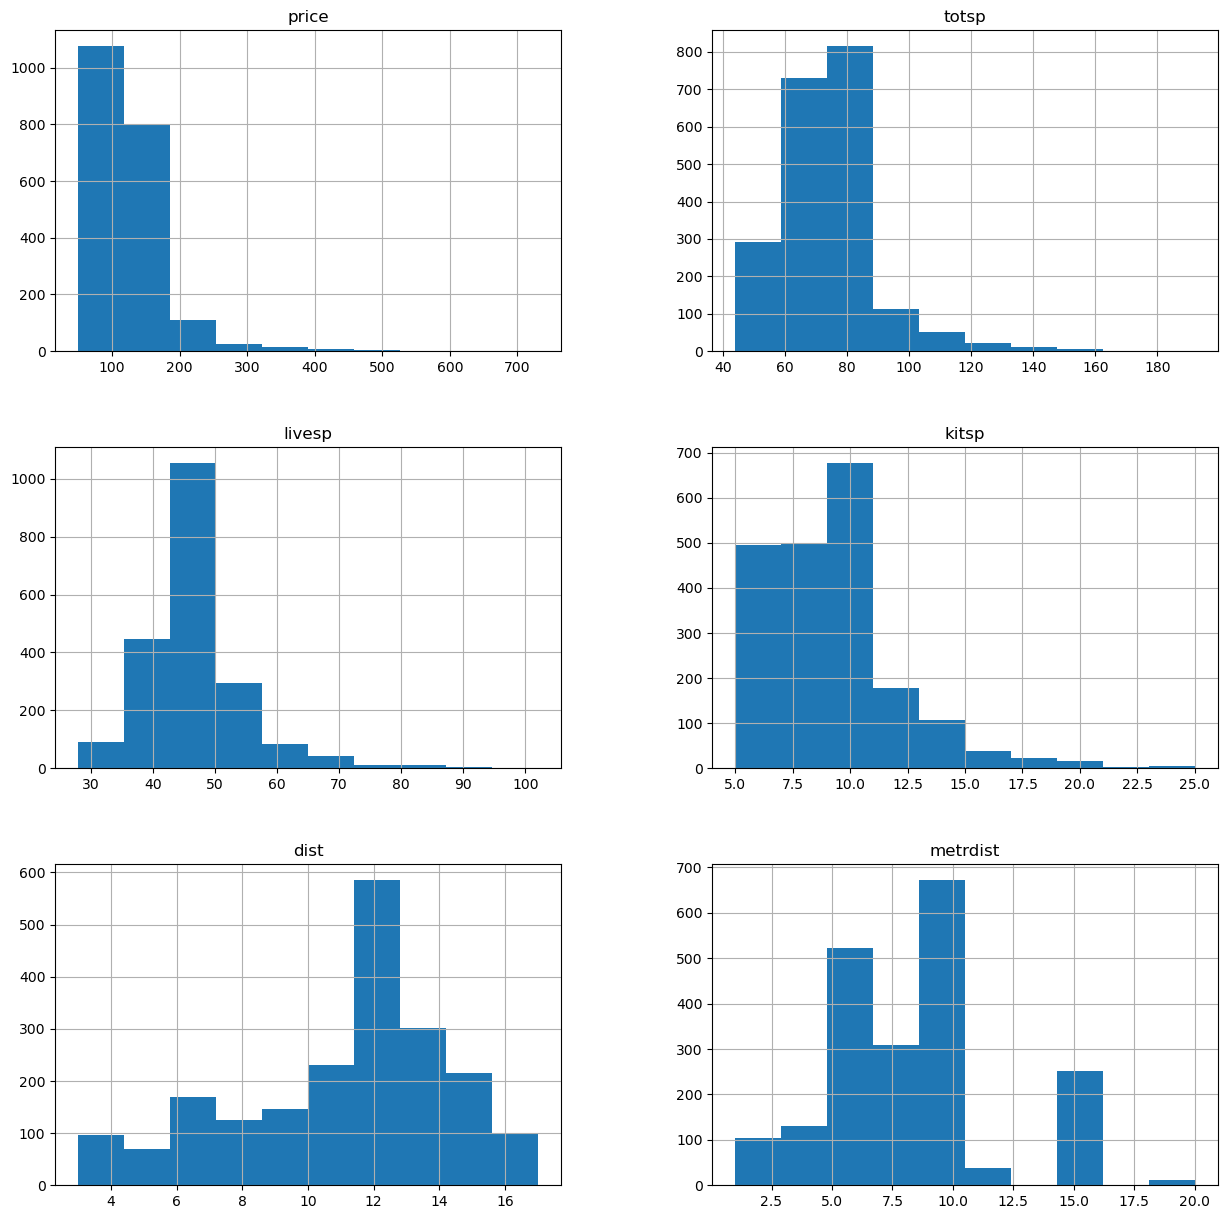

In [7]:
df[num_cols].hist(figsize=(15,15))

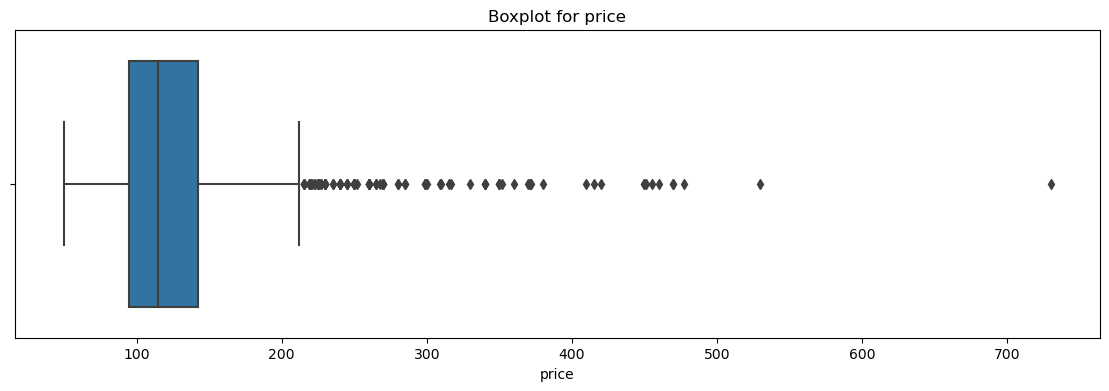

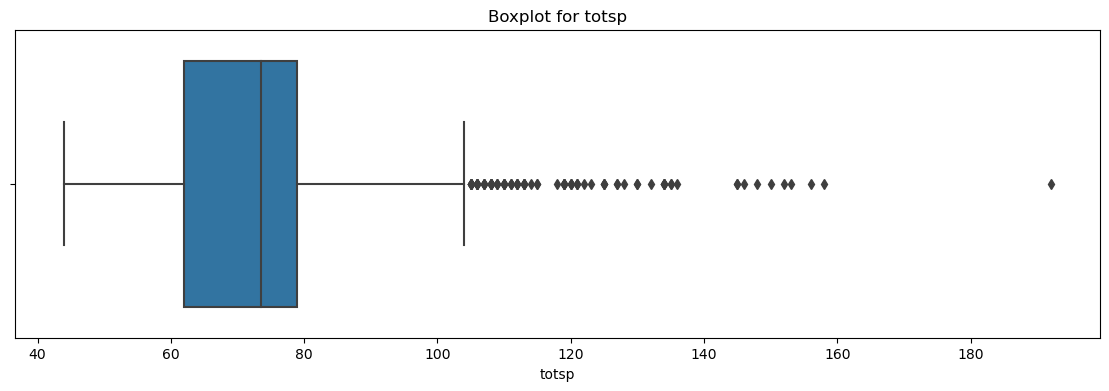

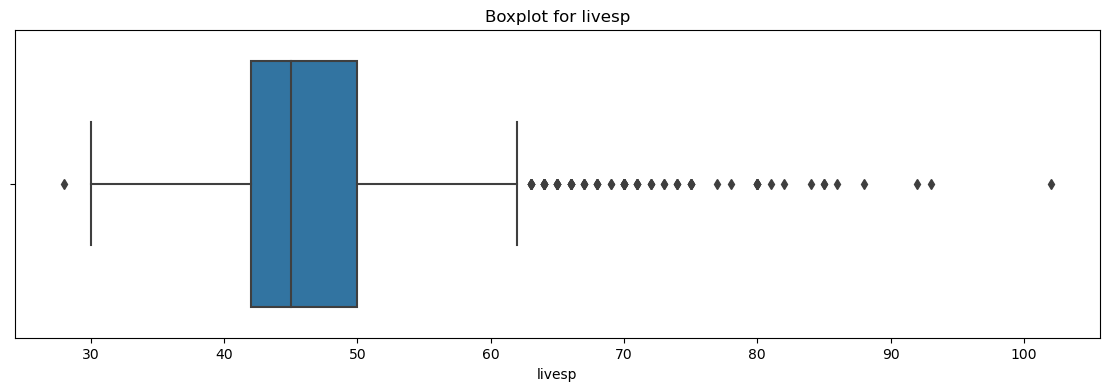

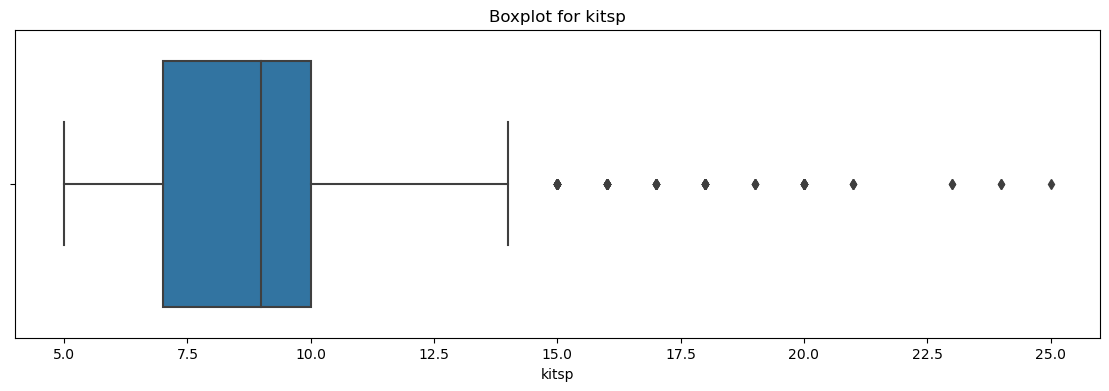

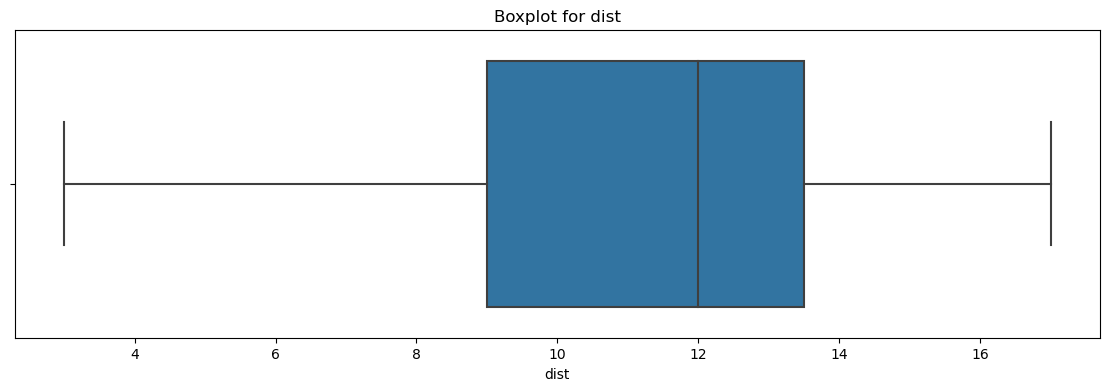

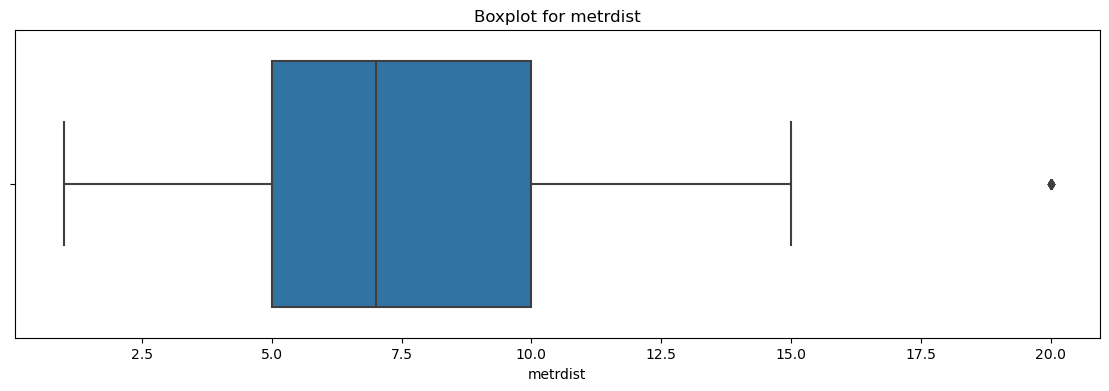

In [8]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col, data=df)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

# Категориальные столбцы

<AxesSubplot:>

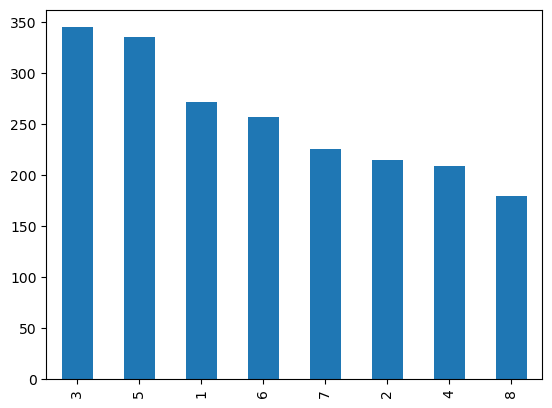

In [9]:
df['code'].value_counts().plot.bar()

# Бинарные столбцы

<AxesSubplot:xlabel='walk', ylabel='count'>

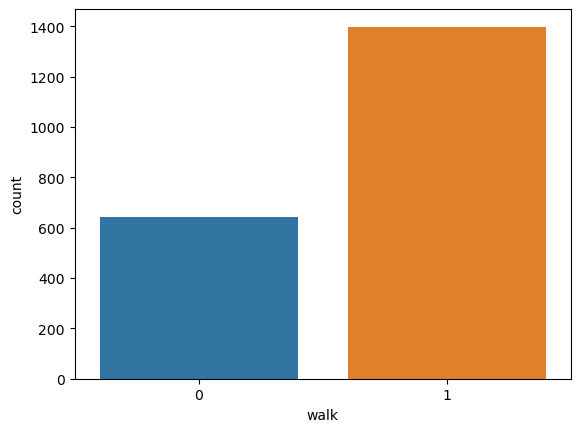

In [10]:
sns.countplot(data=df, x='walk')

<AxesSubplot:xlabel='brick', ylabel='count'>

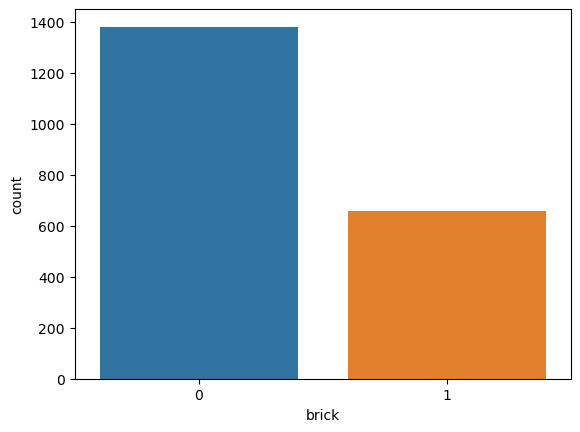

In [11]:
sns.countplot(data=df, x='brick')

<AxesSubplot:xlabel='floor', ylabel='count'>

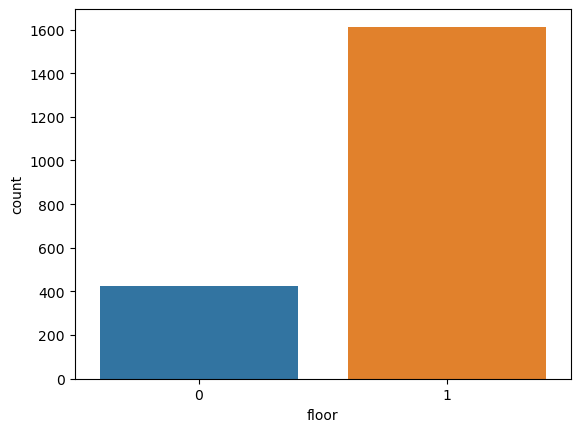

In [12]:
sns.countplot(data=df, x='floor')

<AxesSubplot:>

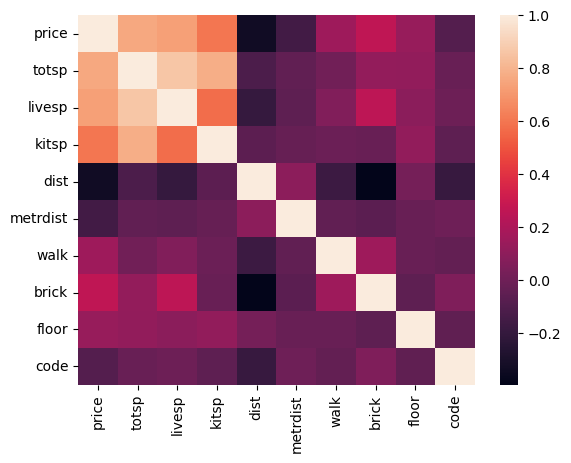

In [13]:
corr = df.corr()
sns.heatmap(corr)

# Сравнение моделей машинного обучения

In [14]:
X = df.drop(['price'], axis=1).values
Y = df['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [15]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
probs = linear_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1414.8003514227987
MAE:  19.937653205005688
RMSE:  37.61383191623526
R2:  0.6580320454547784


In [16]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, rf_regressor.predict(X_test))

MSE:  1002.0105568390774
MAE:  16.439087247121073
RMSE:  31.654550333863178
R2:  0.7578064634982702


0.7578064634982702

In [17]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)
probs = tree_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, tree_regressor.predict(X_test))

MSE:  1902.2764705882353
MAE:  21.915686274509802
RMSE:  43.61509452687493
R2:  0.5402053774072314


0.5402053774072314

In [18]:
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)
probs = kn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, kn_regressor.predict(X_test))

MSE:  1253.5619607843137
MAE:  18.976078431372546
RMSE:  35.405676957012325
R2:  0.6970045849974469


0.6970045849974469

In [19]:
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
probs = svr_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, svr_regressor.predict(X_test))

MSE:  2740.56836028404
MAE:  25.351481968053584
RMSE:  52.35043801425199
R2:  0.33758388205431245


0.33758388205431245

In [20]:
nn_regressor = MLPRegressor()
nn_regressor.fit(X_train, y_train)
probs = nn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, nn_regressor.predict(X_test))

MSE:  1303.3684827893617
MAE:  19.147817586982196
RMSE:  36.10219498575345
R2:  0.6849659716086749


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6849659716086749

In [21]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
probs = xgb_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))
r2_score(y_test, xgb_regressor.predict(X_test))

MSE:  1231.6380583899145
MAE:  17.89168066884957
RMSE:  35.094701286517804
R2:  0.7023037581634148


0.7023037581634148

# Аномальные данные

In [22]:
df.query('price > 500')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
966,730,134,102,10.0,9.0,10,1,1,1,4
1656,530,150,80,15.0,7.5,7,1,1,1,3


In [23]:
df.query('totsp > 180')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
624,455,192,92,18.0,7.5,5,1,0,1,3


In [24]:
df.query('livesp > 90')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
624,455,192,92,18.0,7.5,5,1,0,1,3
966,730,134,102,10.0,9.0,10,1,1,1,4
1528,477,119,93,15.0,9.0,1,1,0,1,3


In [25]:
df.query('kitsp > 22.5')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
520,190,106,58,24.0,9.0,5,0,0,1,4
667,240,105,55,23.0,10.0,5,1,0,1,6
1119,252,132,74,23.0,12.5,3,1,1,0,3
1126,153,80,40,25.0,10.5,10,0,0,1,3
1684,145,76,44,24.0,12.7,2,1,0,0,5


In [26]:
df.query('metrdist > 17.5')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
67,100,78,44,8.0,13.5,20,0,0,1,1
174,50,63,47,7.0,12.0,20,0,1,0,7
245,225,101,65,15.0,10.5,20,1,1,1,3
349,123,79,45,13.0,9.0,20,1,0,1,4
521,132,84,52,11.0,12.7,20,1,0,1,5
550,107,65,39,8.0,12.5,20,1,0,1,2
690,100,78,44,9.0,13.5,20,0,0,1,1
913,110,71,43,10.0,14.5,20,0,0,1,3
1005,100,72,42,10.0,14.5,20,0,0,0,3
1608,112,66,44,7.0,8.0,20,1,0,1,1


<AxesSubplot:xlabel='totsp', ylabel='price'>

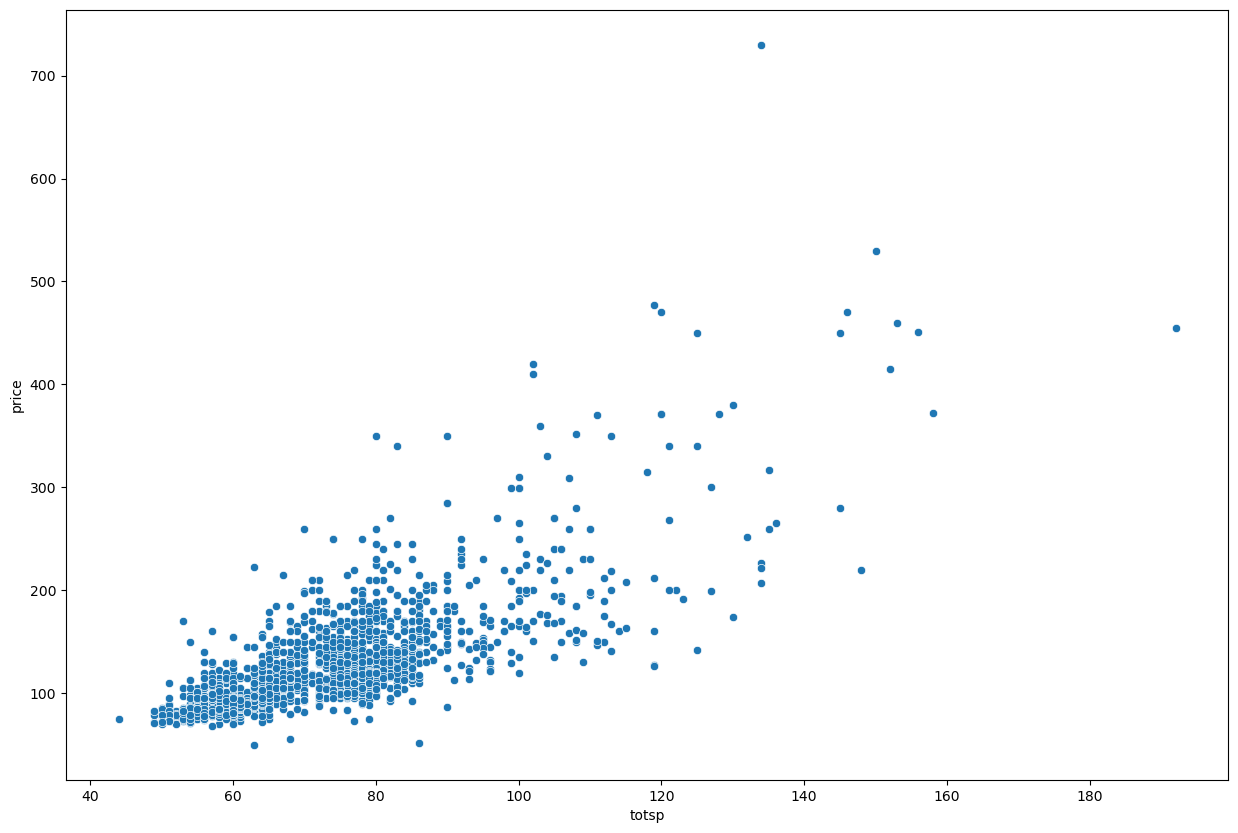

In [27]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.totsp, y=df.price)

In [28]:
df.drop(index = [624, 966], inplace = True)
df.shape

(2038, 10)

# Результаты после

In [29]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
probs = linear_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1414.8003514227987
MAE:  19.937653205005688
RMSE:  37.61383191623526
R2:  0.6580320454547784


In [30]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1018.3502446706391
MAE:  16.61281621537504
RMSE:  31.91160047178203
R2:  0.7538570372629378


In [31]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)
probs = tree_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1675.6720043572984
MAE:  21.65032679738562
RMSE:  40.934972875980975
R2:  0.5949773922218133


In [32]:
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)
probs = kn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1253.5619607843137
MAE:  18.976078431372546
RMSE:  35.405676957012325
R2:  0.6970045849974469


In [33]:
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
probs = svr_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  2740.56836028404
MAE:  25.351481968053584
RMSE:  52.35043801425199
R2:  0.33758388205431245


In [34]:
nn_regressor = MLPRegressor()
nn_regressor.fit(X_train, y_train)
probs = nn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1274.2660194008042
MAE:  18.970278482035297
RMSE:  35.696862878981456
R2:  0.692000257306444


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [35]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
probs = xgb_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1231.6380583899145
MAE:  17.89168066884957
RMSE:  35.094701286517804
R2:  0.7023037581634148


# Анализ данных

<AxesSubplot:xlabel='kitsp', ylabel='price'>

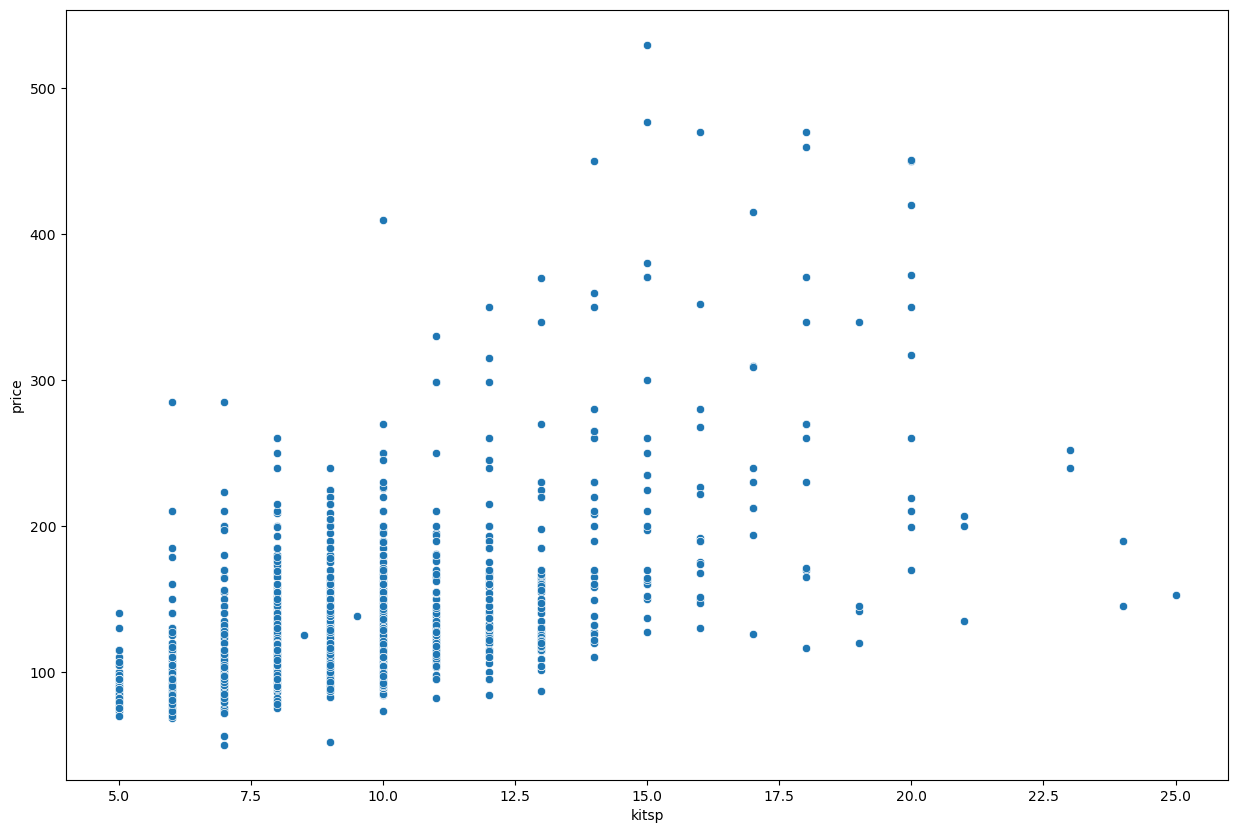

In [36]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.kitsp, y=df.price)

Зависимость от цены кухни небольшая, даже, удивительно несколько дома с особенно большими кухнями, стоят дешевле аналогов, возможно потому что это пространство "ворует" площадь остальных комнат

<AxesSubplot:xlabel='totsp', ylabel='kitsp'>

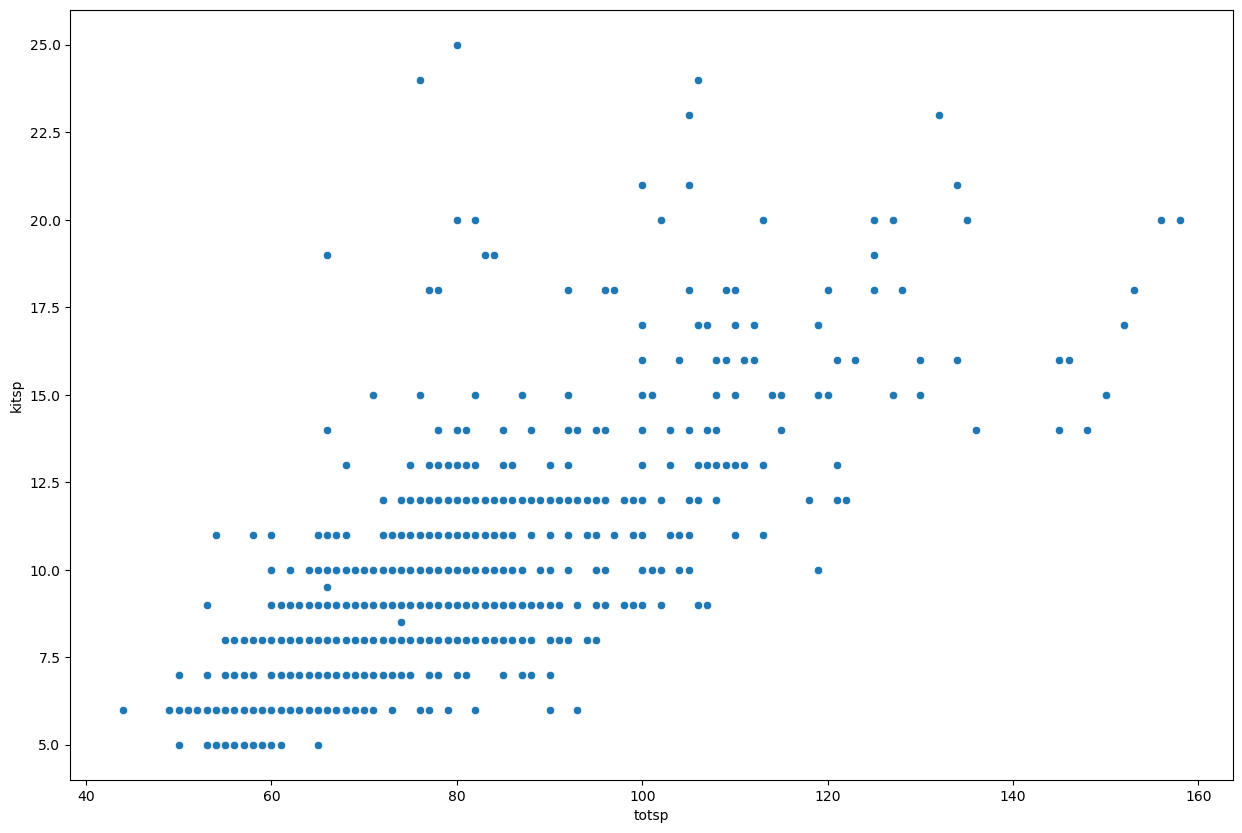

In [47]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.totsp, y=df.kitsp)

In [ ]:
Пара выбывияшихся точек ближе к верхнему левому углу подтверждают нашу теорию

<AxesSubplot:xlabel='livesp', ylabel='price'>

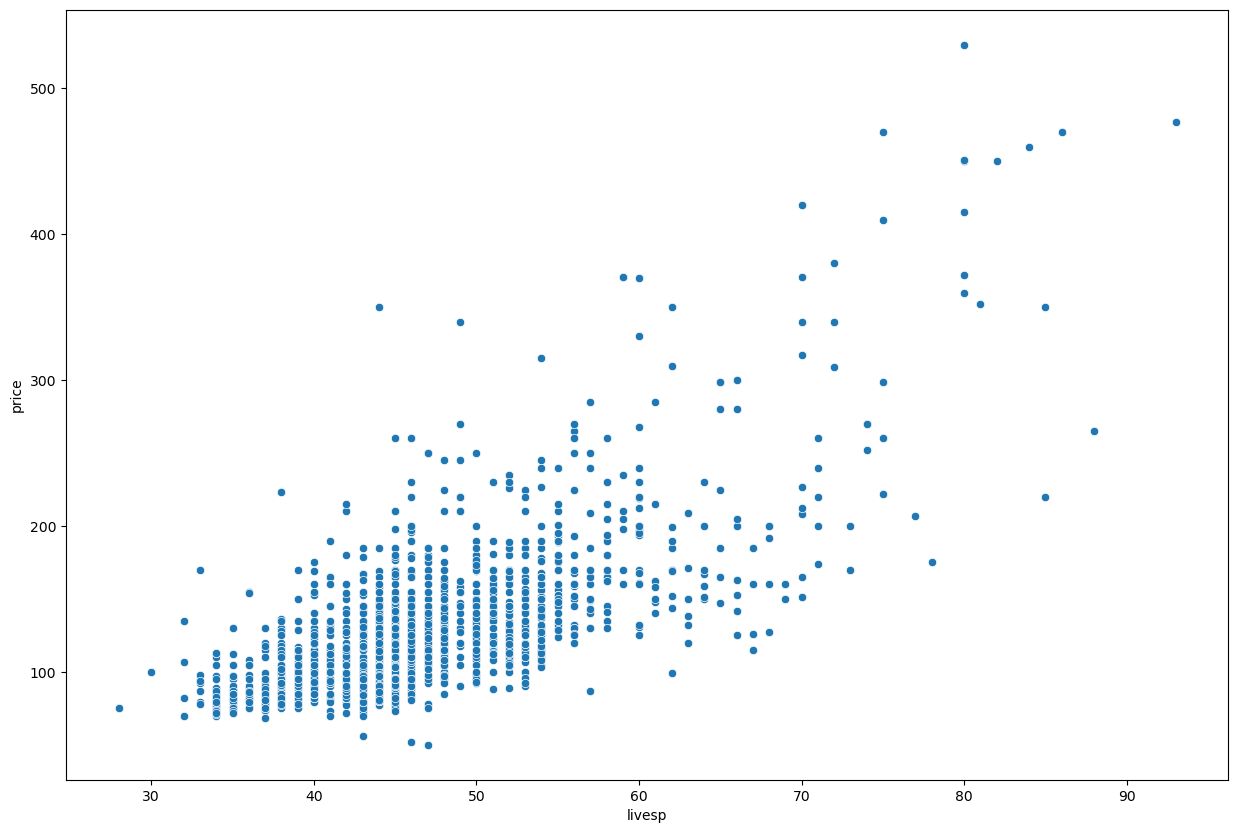

In [38]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.livesp, y=df.price)

In [ ]:
Жилая площадь показывает почти такую же зависимость как и общая площадь

<AxesSubplot:xlabel='dist', ylabel='price'>

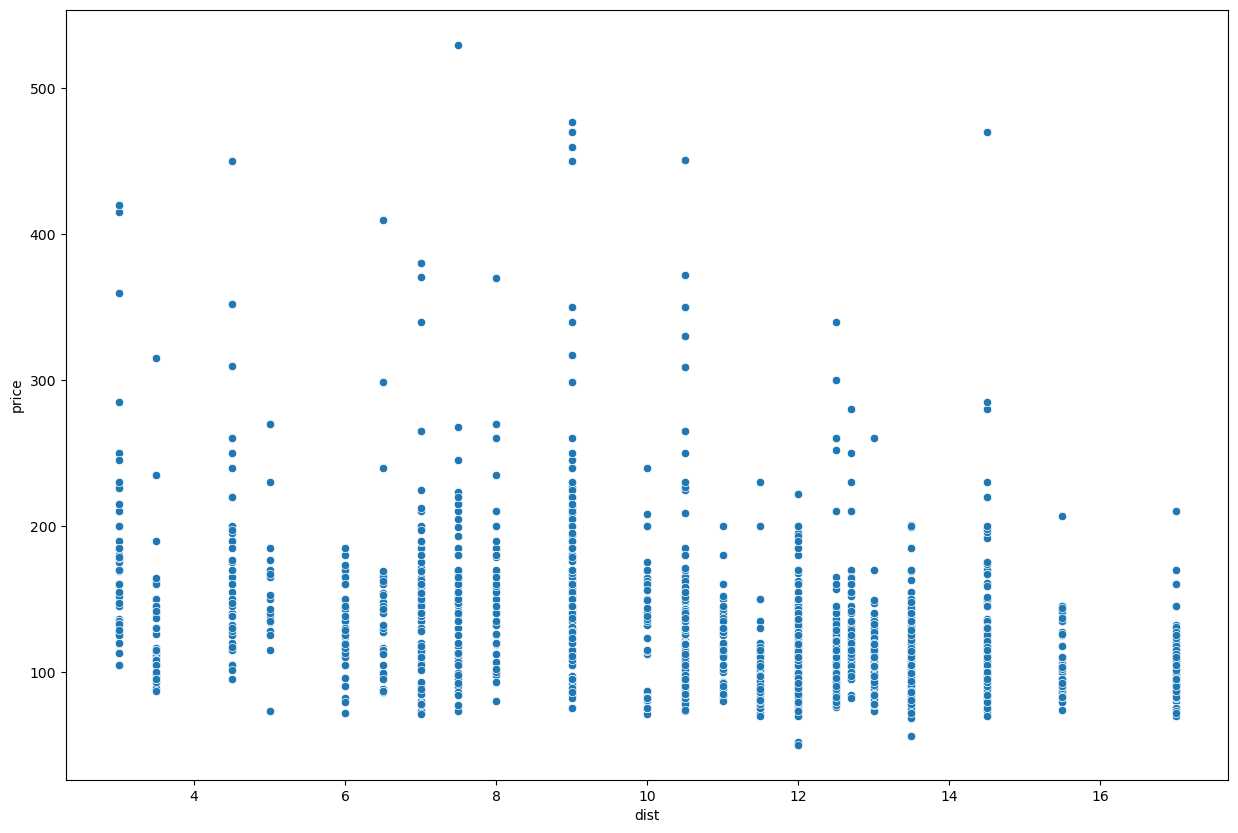

In [40]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.dist, y=df.price)

<AxesSubplot:xlabel='metrdist', ylabel='price'>

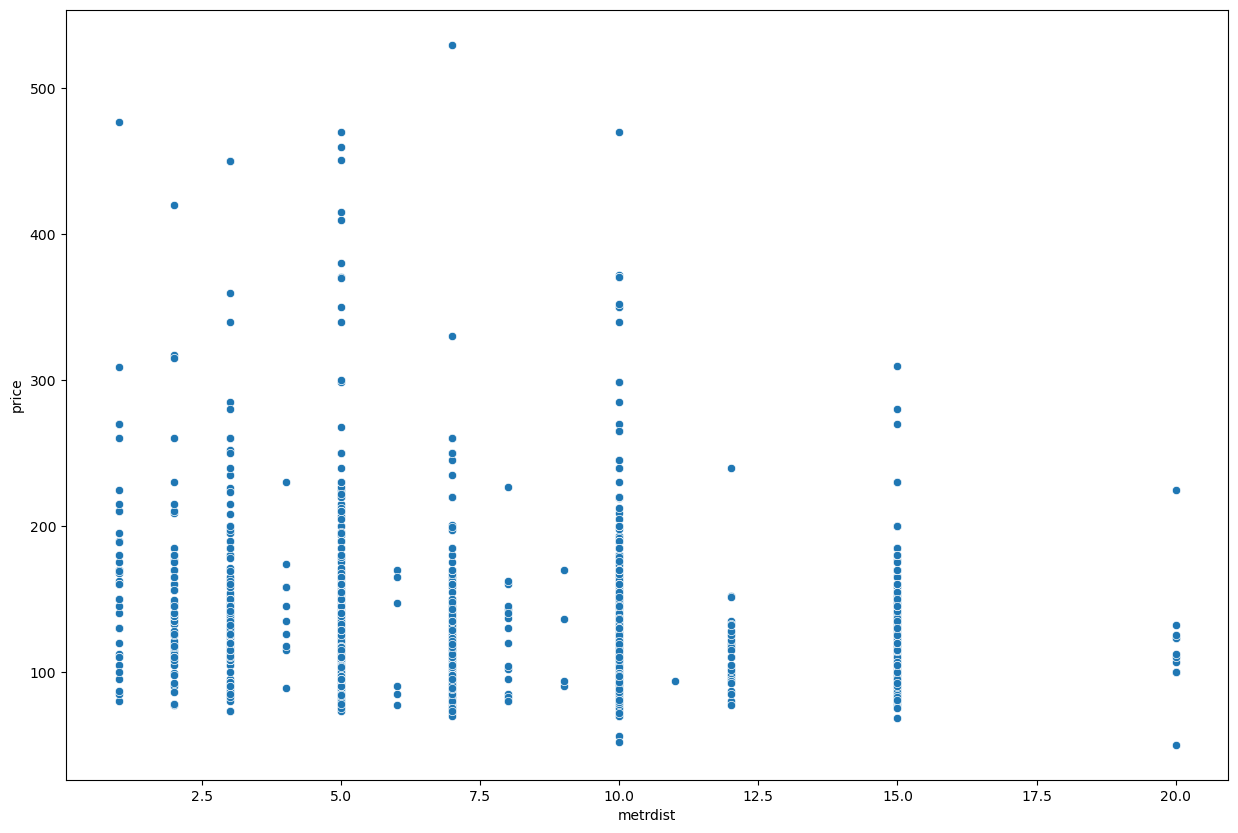

In [39]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.metrdist, y=df.price)

Расстояние от центра и от метро показывает лишь только, что люди не хотят платить много за квартиры "слишком" далеко от центра/метро (>16-20 м), но в остальном другие параметры берут предпочтение

<AxesSubplot:xlabel='metrdist', ylabel='totsp'>

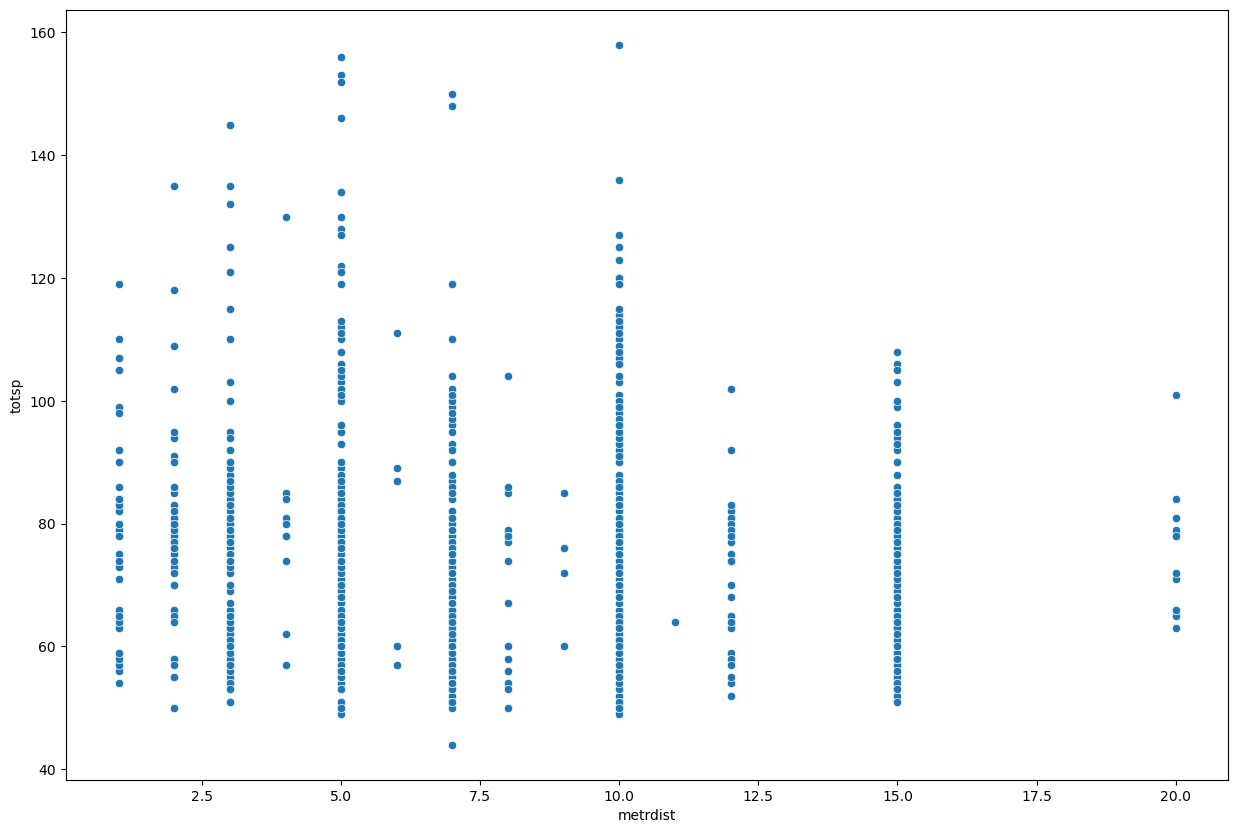

In [48]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.metrdist, y=df.totsp)

<AxesSubplot:xlabel='metrdist', ylabel='totsp'>

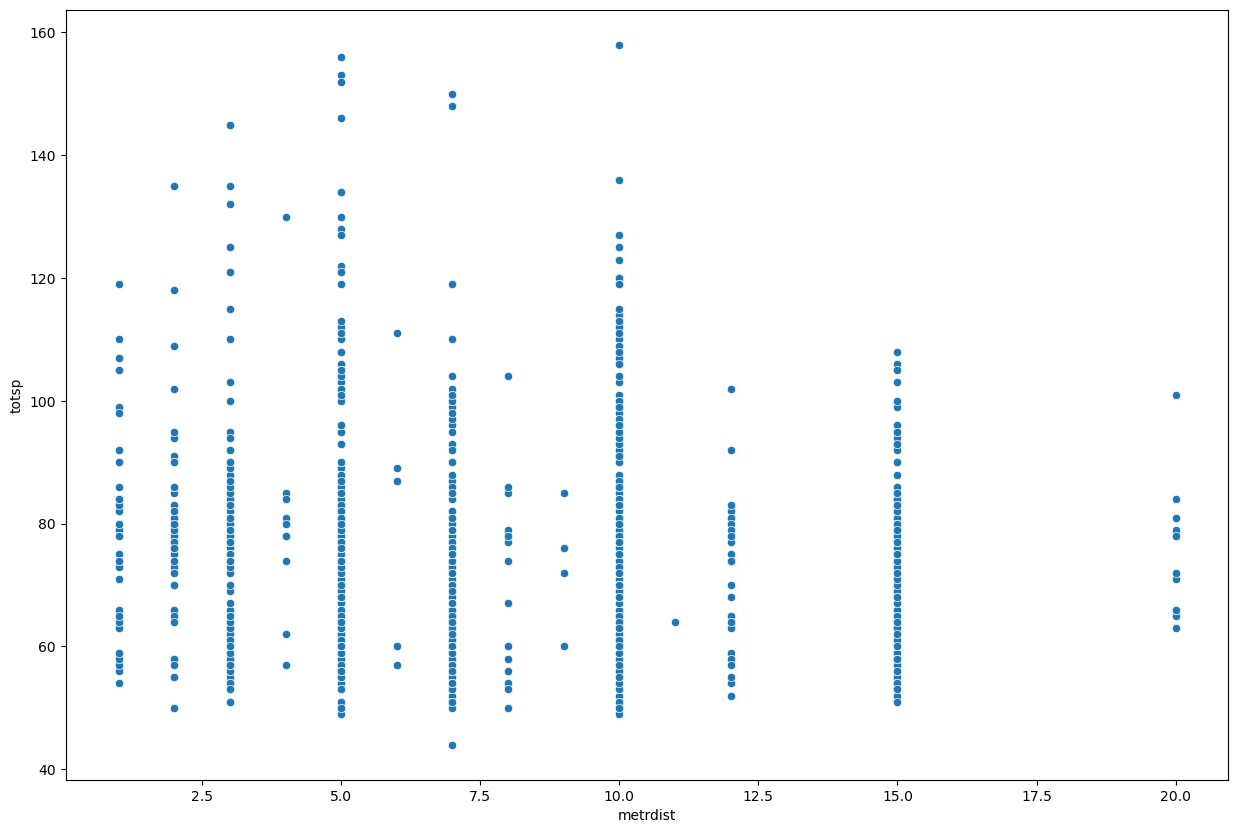

In [49]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.metrdist, y=df.totsp)

Если заменить цену на общую площадь, то картина почти не меняется, что опять же показывает важность именно площади квартиры перед другими факторами

<AxesSubplot:xlabel='walk', ylabel='price'>

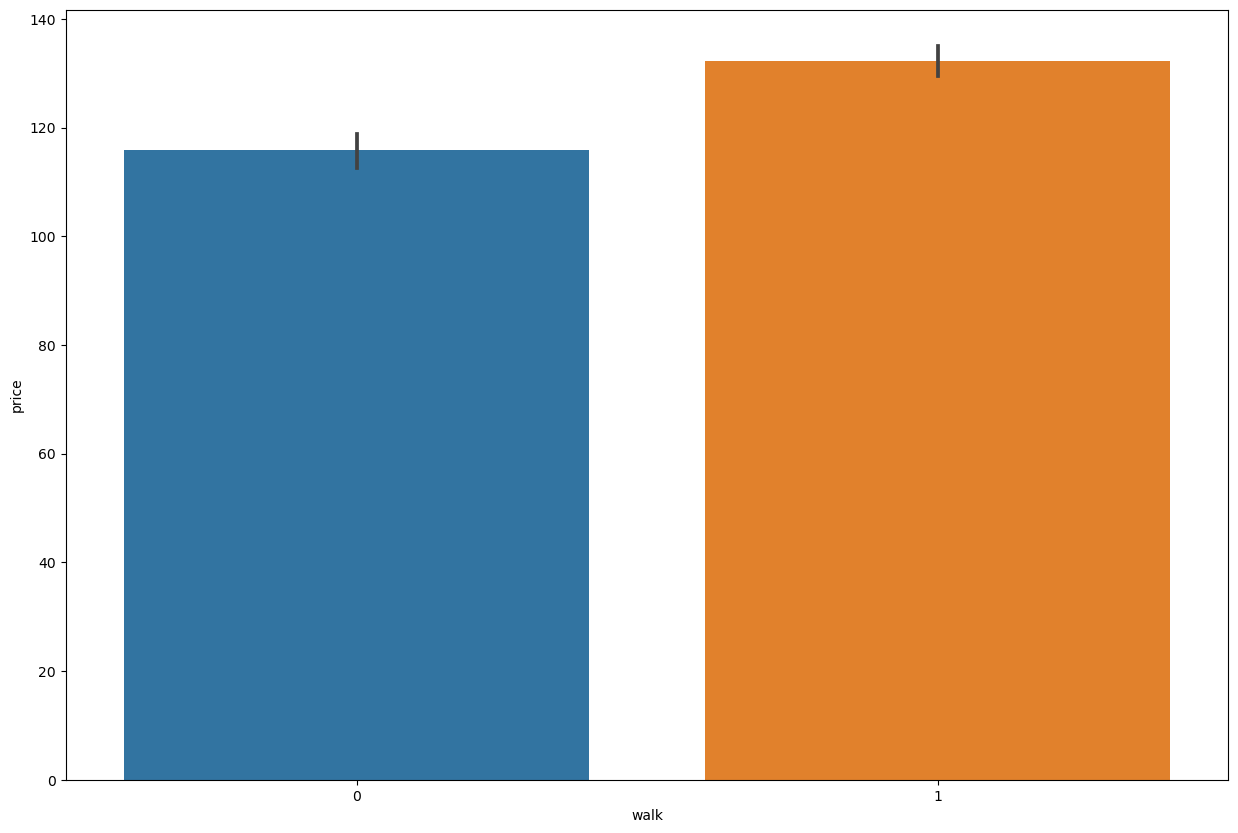

In [46]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.walk, y=df.price)

<AxesSubplot:xlabel='walk', ylabel='totsp'>

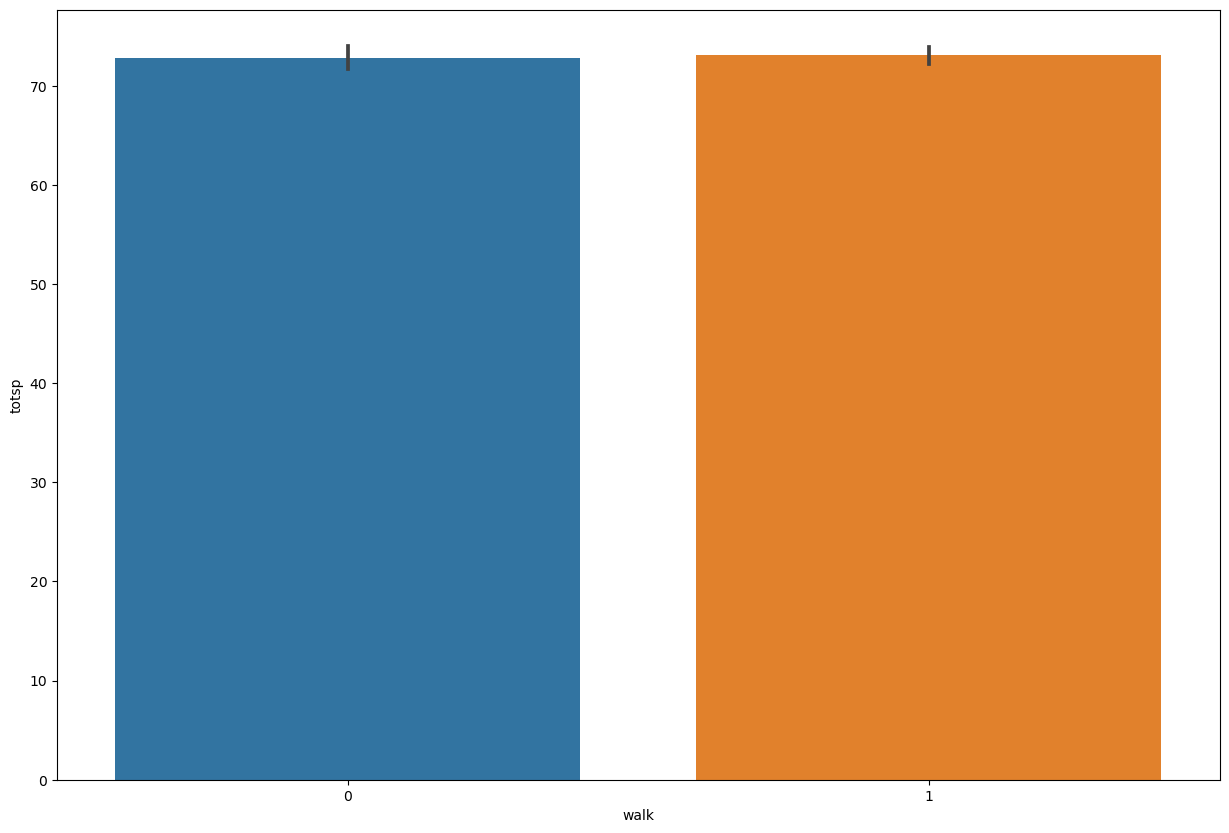

In [50]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.walk, y=df.totsp)

При этом явно видно, что возможность добраться до метро добавляет стоимости, то есть не столь важна удаленность, сколько возможность

<AxesSubplot:xlabel='brick', ylabel='price'>

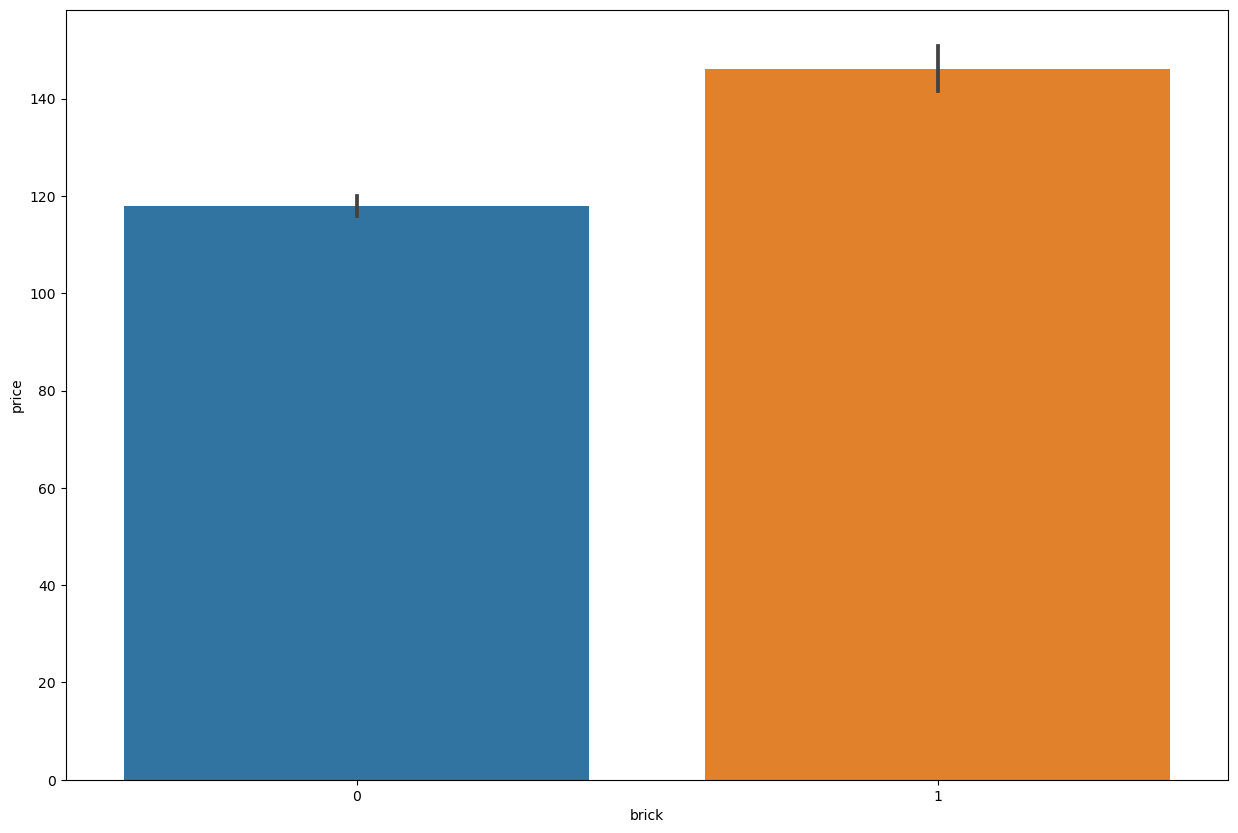

In [42]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.brick, y=df.price)

<AxesSubplot:xlabel='brick', ylabel='totsp'>

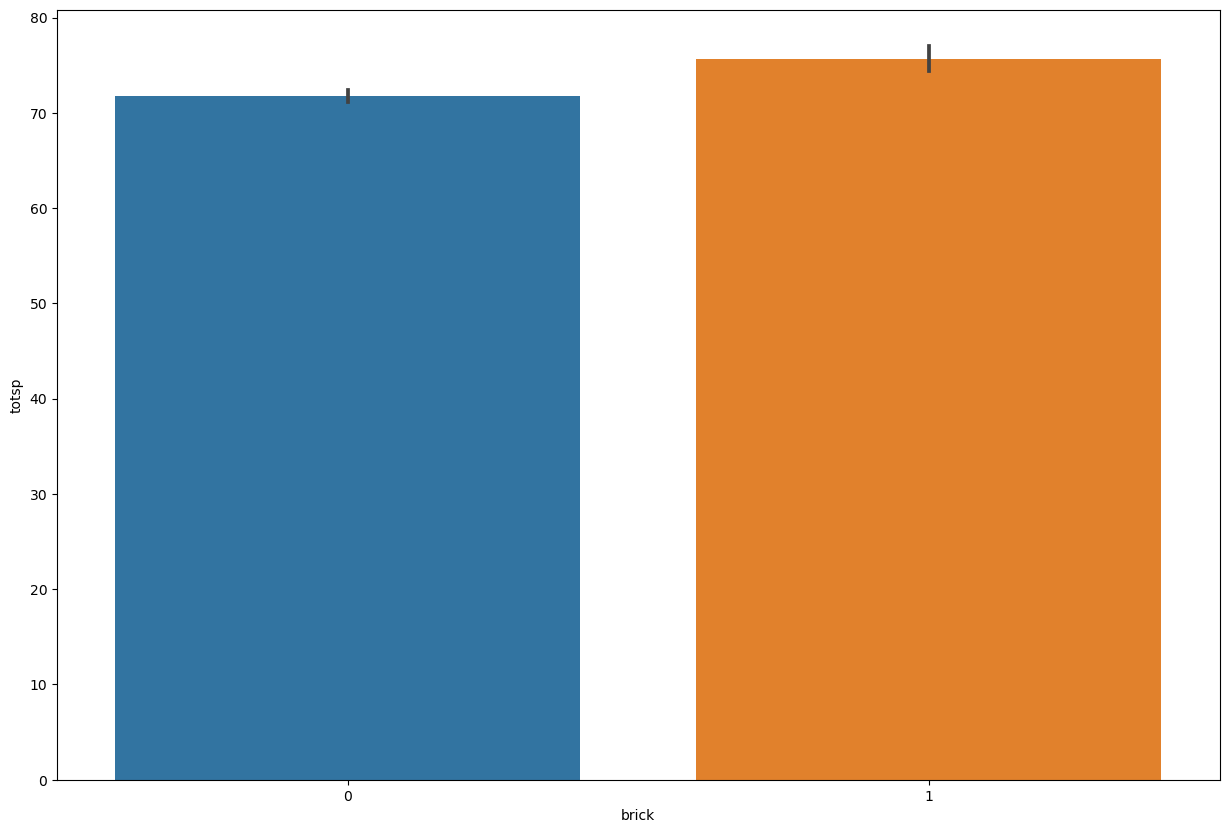

In [52]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.brick, y=df.totsp)

<AxesSubplot:xlabel='floor', ylabel='price'>

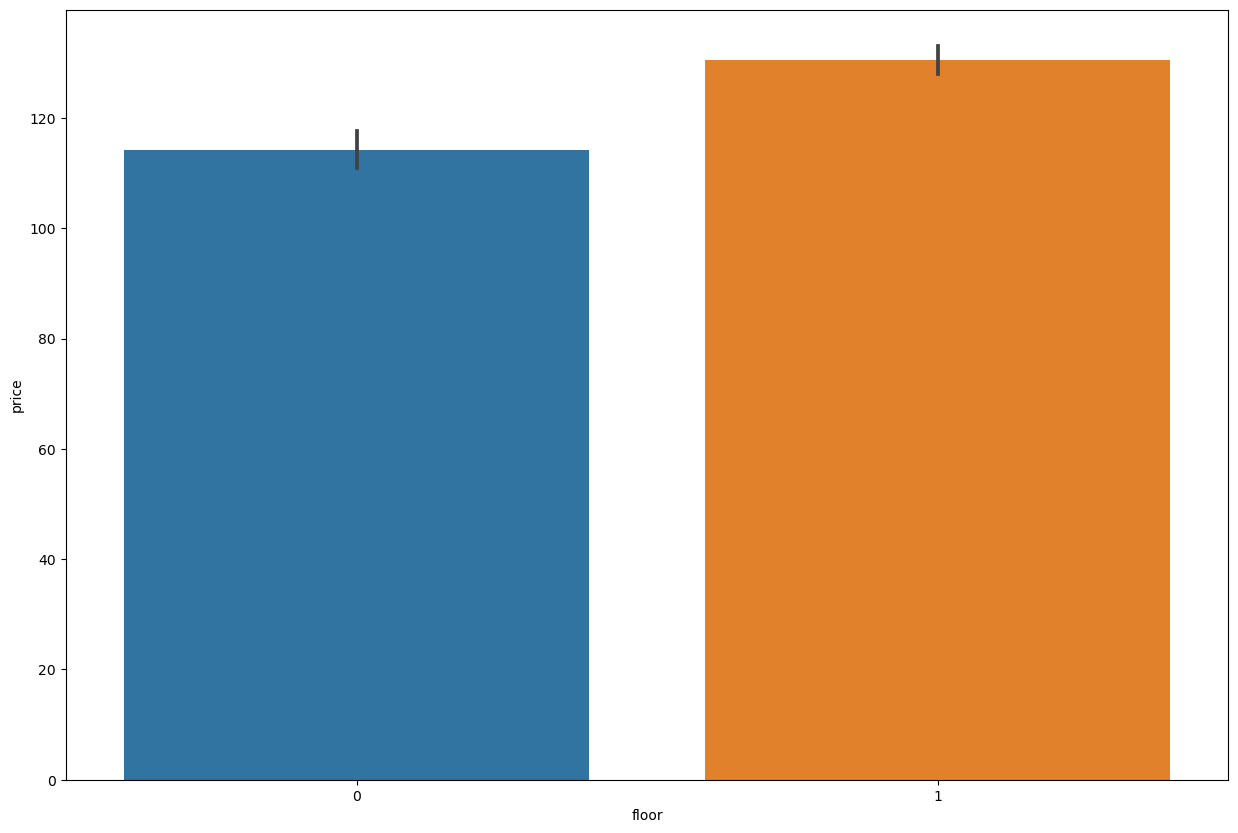

In [53]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.floor, y=df.price)

<AxesSubplot:xlabel='floor', ylabel='totsp'>

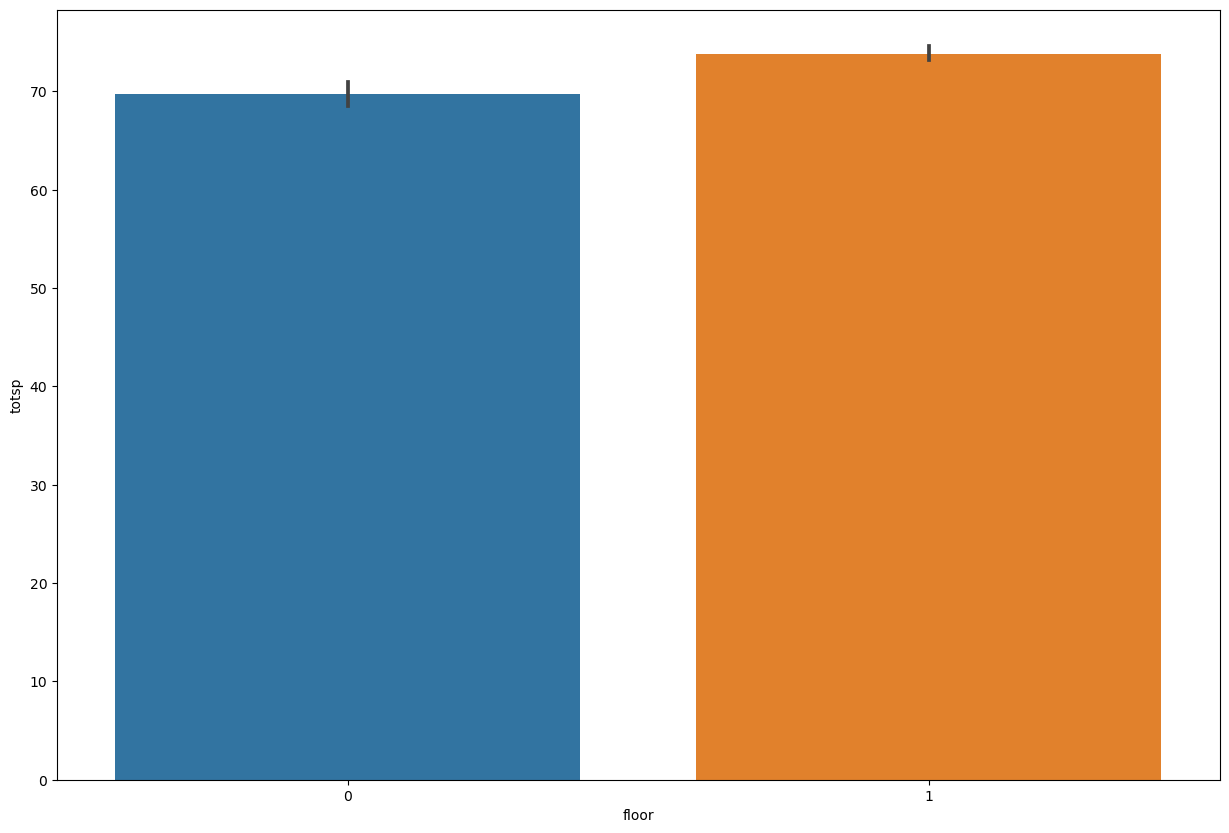

In [54]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.floor, y=df.totsp)

<AxesSubplot:xlabel='code', ylabel='price'>

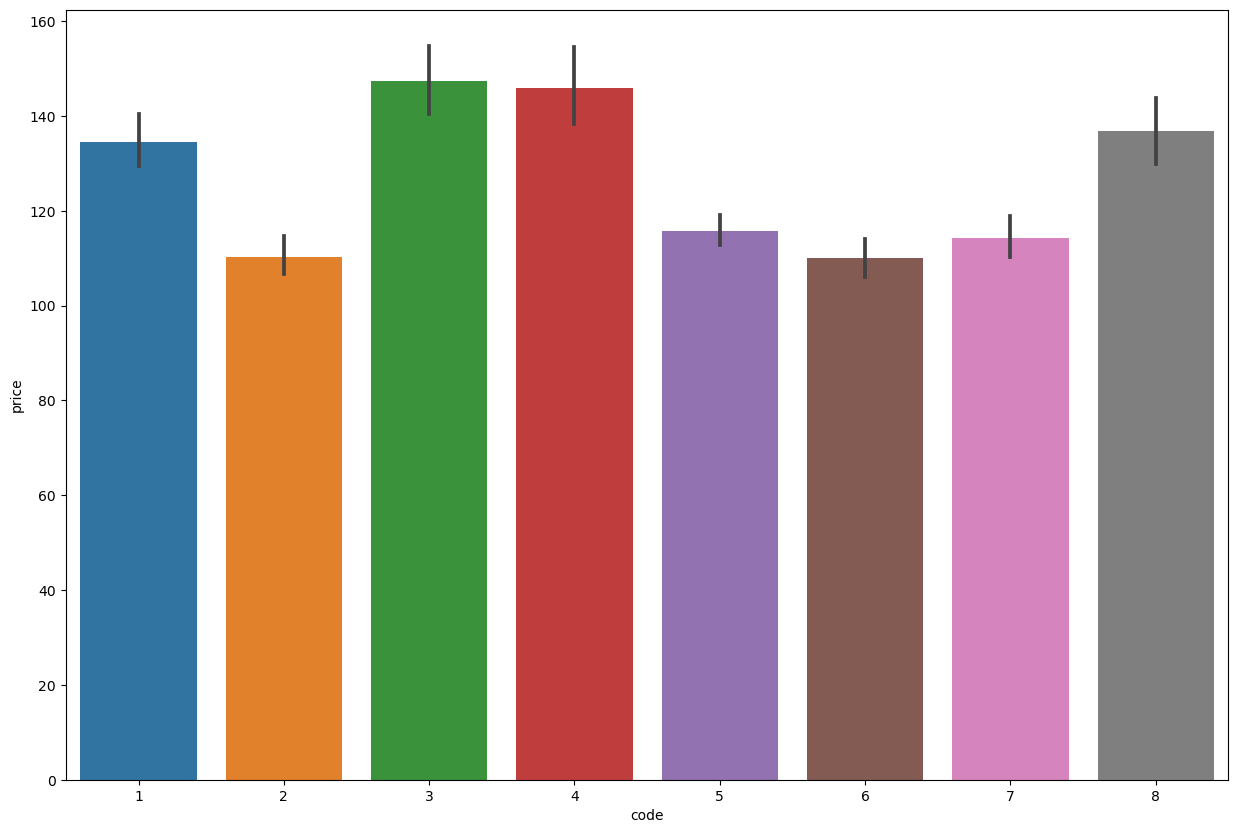

In [44]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.code, y=df.price)

Из районов можно выделить 4 "хороших" - 1, 3, 4, 8. Сделаем это отдельным признаком и посмотрим на результаты

In [67]:
def code_map(code):
    if code == 2:
        return 0
    elif code == 5:
        return 0
    elif code == 6:
        return 0
    elif code == 7:
        return 0
    else:
        return 1
 
df['good_neighbourhood'] = df['code'].map(code_map)
display(df.head())

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,good_neighbourhood
0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,75,44,28,6.0,13.5,7,1,0,1,6,0
2,128,70,42,6.0,14.5,3,1,1,1,3,1
3,95,61,37,6.0,13.5,7,1,0,1,1,1
4,330,104,60,11.0,10.5,7,0,1,1,3,1


In [68]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  990.7421107731072
MAE:  16.625058053221288
RMSE:  31.47605615024073
R2:  0.7605301322111085


0.7605301322111085

In [69]:
df.drop('code', axis = 1)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,good_neighbourhood
0,81,58,40,6.0,12.5,7,1,1,1,1
1,75,44,28,6.0,13.5,7,1,0,1,0
2,128,70,42,6.0,14.5,3,1,1,1,1
3,95,61,37,6.0,13.5,7,1,0,1,1
4,330,104,60,11.0,10.5,7,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2035,110,77,45,10.0,12.0,5,0,0,1,0
2036,95,60,43,6.0,9.0,5,0,0,1,1
2037,95,60,46,5.0,10.5,5,1,0,1,0
2038,129,76,48,10.0,12.5,5,0,0,1,1


In [70]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1030.2374329181848
MAE:  16.677453594771244
RMSE:  32.097311926673626
R2:  0.7509838138811235


In [71]:
df.drop('metrdist', axis = 1)
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  995.337827207232
MAE:  16.652806499872675
RMSE:  31.548975057951278
R2:  0.7594193127608115


In [72]:
df.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,good_neighbourhood
0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,75,44,28,6.0,13.5,7,1,0,1,6,0
2,128,70,42,6.0,14.5,3,1,1,1,3,1
3,95,61,37,6.0,13.5,7,1,0,1,1,1
4,330,104,60,11.0,10.5,7,0,1,1,3,1
